## <center>CITS5508 Lab sheet 3: Decision Tree Classification</center>

**Name: Smaule Heath**<br>
**Student number: 21725083**<br>

Looks at two different datasets and performs Decision Tree Classification on each set.

### Project 1 - UCI ecoli Dataset
#### Load Data from `./ecoli.data` and stratified split the data

### Split the dataset using StratifiedShuffleSplit on the labels

In [49]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

random_seed = 12

labels = ["sequence", "mcg", "gvh", "lip", "chg", "aac", "alm1", "alm2", "label"]
#TODO Load data from a url if the local file cannot be loaded

ecoli_data = pd.read_csv('./ecoli.data', delim_whitespace=True, names=labels)

#ecoli_data = ecoli_data.drop(["remove"], axis=1)

ecoli_data.head(10)

,sequence,mcg,gvh,lip,chg,aac,alm1,alm2,label
0,AAT_ECOLI,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,ACEA_ECOLI,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,ACEK_ECOLI,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,ACKA_ECOLI,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,ADI_ECOLI,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp
5,ALKH_ECOLI,0.67,0.39,0.48,0.5,0.36,0.38,0.46,cp
6,AMPD_ECOLI,0.29,0.28,0.48,0.5,0.44,0.23,0.34,cp
7,AMY2_ECOLI,0.21,0.34,0.48,0.5,0.51,0.28,0.39,cp
8,APT_ECOLI,0.20,0.44,0.48,0.5,0.46,0.51,0.57,cp
9,ARAC_ECOLI,0.42,0.40,0.48,0.5,0.56,0.18,0.30,cp


## Check the class distribution and remove those with < 10

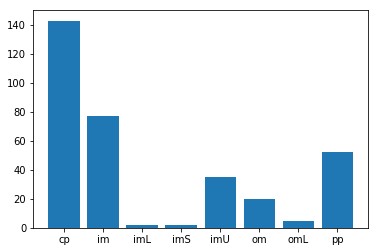

In [50]:
import matplotlib.pyplot as plt

ecoli_data_copy = ecoli_data.copy()

plt.bar(x=ecoli_data_copy.sort_values('label')['label'].unique(), height=ecoli_data_copy.groupby('label').size())
plt.show()

From this we see that imL, imS, and omL cannot be used for classificiation due to their low number of training instances, so lets remove these classes from the dataset.

In [54]:
ecoli_data = ecoli_data.drop(labels=["imL", "imS", "omL"])

ValueError: Cannot specify both 'labels' and 'index'/'columns'

## Split the dataset into training and testing datasets

In [41]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(random_state=random_seed, test_size=0.2, train_size=0.8)
ecoli_train, ecoli_test = sss.split(ecoli_data["sequence"], ecoli_data.iloc[:, 1:])

# Scale the Data

print(ecoli_train.describe())
ecoli_test.describe()

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

### Decision Tree

In [9]:
from sklearn.tree import DecisionTree

dt = DecisionTree().fit(ecoli_train, ecoli_label)



ImportError: cannot import name 'DecisionTree' from 'sklearn.tree' (c:\users\gosia\documents\cits5508\venv\lib\site-packages\sklearn\tree\__init__.py)

### Support Vector Machine Normalized

In [11]:
from sklearn.svm import SVC
from sklearn.metrics impor predict_cross_validation

svm = SVC().fit(ecoli_train, ecoli_train_label)


SyntaxError: invalid syntax (<ipython-input-11-85b6366bc4ae>, line 2)

### Support Vector Machine Unnormalized

### Project 2 - BOM Dataset
#### Load Data from ``